In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import MobileNet
from keras.utils import Sequence
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

dataset_code = 'D'
model_name = 'MobileNet'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
train_data_path = os.path.join(data_saved_dir, f'{dataset_code}_training.pkl')
train_images, train_labels = load_pickle(train_data_path)

val_data_path = os.path.join(data_saved_dir, 'validation_data.pkl')
val_images, val_labels = load_pickle(val_data_path)

In [3]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

batch_size = 16
train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)

In [4]:
mobile_net = MobileNet(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

model = Sequential()
model.add(mobile_net)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2048)              134219776 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 137,450,689
Trainable params: 134,221,825
Non-trainable params: 3,228,864
__________________________________

In [5]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator)

Epoch 1/50
300/300 [==============================] - 16s 41ms/step - loss: 5.1843 - accuracy: 0.8716 - val_loss: 0.6165 - val_accuracy: 0.9414
Epoch 2/50
300/300 [==============================] - 11s 37ms/step - loss: 0.2544 - accuracy: 0.9678 - val_loss: 0.2801 - val_accuracy: 0.9623
Epoch 3/50
300/300 [==============================] - 11s 37ms/step - loss: 0.0812 - accuracy: 0.9814 - val_loss: 0.3677 - val_accuracy: 0.9582
Epoch 4/50
300/300 [==============================] - 11s 37ms/step - loss: 0.0519 - accuracy: 0.9877 - val_loss: 0.4865 - val_accuracy: 0.9289
Epoch 5/50
300/300 [==============================] - 11s 36ms/step - loss: 0.0844 - accuracy: 0.9848 - val_loss: 0.5851 - val_accuracy: 0.9372
Epoch 6/50
300/300 [==============================] - 11s 37ms/step - loss: 0.1138 - accuracy: 0.9825 - val_loss: 0.6920 - val_accuracy: 0.9498
Epoch 7/50
300/300 [==============================] - 11s 36ms/step - loss: 0.4092 - accuracy: 0.9622 - val_loss: 0.9761 - val_accuracy:

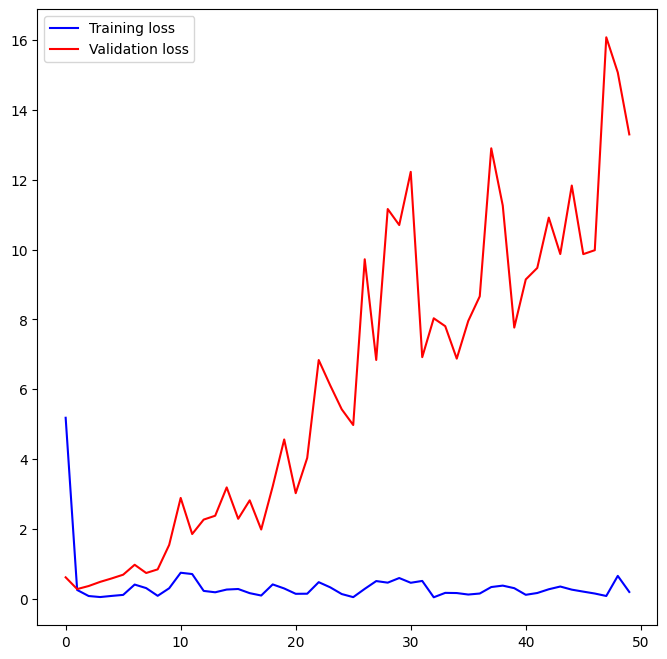

<Figure size 640x480 with 0 Axes>

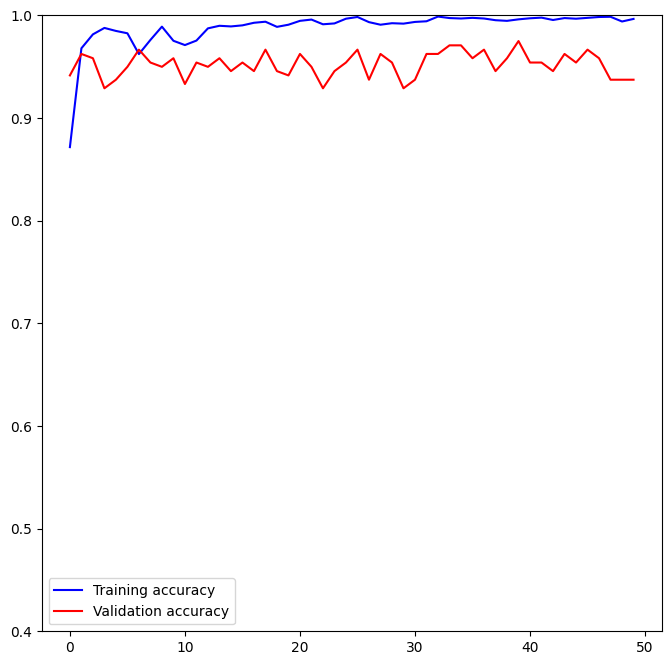

In [6]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.4, 1)
plt.show()

8/8 [==============================] - 1s 55ms/step


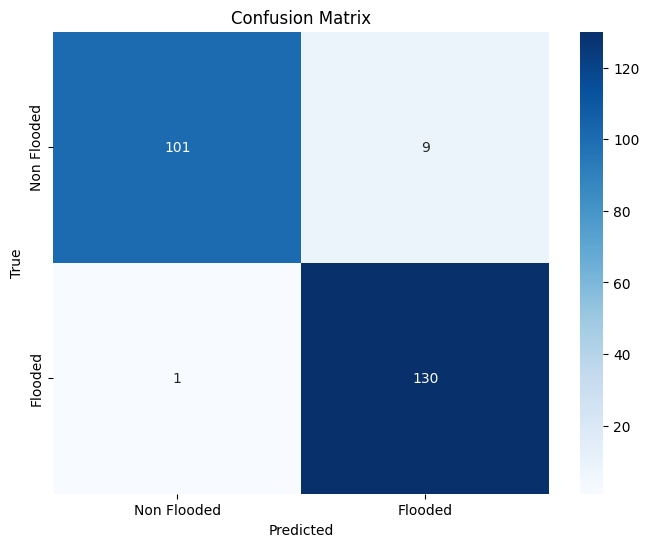

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       110
           1       0.94      0.99      0.96       131

    accuracy                           0.96       241
   macro avg       0.96      0.96      0.96       241
weighted avg       0.96      0.96      0.96       241



In [7]:
test_data_path = os.path.join(data_saved_dir, 'test_data.pkl')
test_images, test_labels = load_pickle(test_data_path)

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [8]:
# model_saved = r'D:\My Code\Classification\models'
# model.save(os.path.join(model_saved, f'{dataset_code}_{model_name}  (256X256).h5'))

In [11]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

data_dir = r"D:\Datasets\AIDER\classification"
target_size = (224, 224)
batch_size = 32

classes = sorted(os.listdir(data_dir))

X_data = []
y_data = []

for class_label in classes:
    class_path = os.path.join(data_dir, class_label)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        X_data.append(img_array)
        y_data.append(classes.index(class_label))

X_test = np.array(X_data)
y_test = np.array(y_data)

random_seed = 42
np.random.seed(random_seed)

indices = np.arange(len(X_test))
np.random.shuffle(indices)

X_test = X_test[indices]
y_test = y_test[indices]

X_test = X_test / 255.0

predictions = model.predict(X_test)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, predicted_labels))

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Abdul Manaf\AppData\Local\Temp\ipykernel_3532\2809693677.py", line 38, in <module>
      predictions = model.predict(X_test)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\reshaping\flatten.py", line 98, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 1605632 values, but the requested shape requires a multiple of 65536
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_predict_function_70548]